In [1]:
import pandas as pd
dataset = pd.read_csv("dataset.csv")

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
import pandas as pd
import numpy as np



# Check class distribution
class_distribution = dataset['target'].value_counts()
print("Class Distribution Before Balancing:")
print(class_distribution)

# Determine the majority class and minority class
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
print(minority_class)

# Get the number of samples in the majority class
majority_class_count = class_distribution[majority_class]
minority_class_count = class_distribution[minority_class]
print(minority_class_count)

# Find indices of majority class samples
majority_indices = dataset[dataset['target'] == majority_class].index

# Randomly select majority class samples to drop
drop_indices = np.random.choice(majority_indices, size=majority_class_count - minority_class_count, replace=False)

# Drop selected majority class samples
balanced_df = dataset.drop(drop_indices)

# Check class distribution after balancing
balanced_class_distribution = balanced_df['target'].value_counts()
print("\nClass Distribution After Balancing:")
print(balanced_class_distribution)


Class Distribution Before Balancing:
target
0    1225312
1      80810
Name: count, dtype: int64
1
80810

Class Distribution After Balancing:
target
0    80810
1    80810
Name: count, dtype: int64


In [3]:
#preprocessing text
import nltk
from nltk.tokenize import word_tokenize # 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# clean data และจัดการข้อความให้อยู่ในรูปแบบที่ง่ายต่อการเรียนรู้
# เราจะใช้ library nltk ทำขั้นตอน preprocess ดังนี้
# tokenization
# stopword removal
# stemming by using porter stemmer

porter = PorterStemmer()
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
#     print(filtered_tokens)
    return " ".join(filtered_tokens)

# preprocess all training data
X_preprocessed = [preprocess_text(text) for text in balanced_df['question_text']]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# #divide dataset into to two pieces cosisted of training part and test part
sentences_train, sentences_test, y_train, y_test = train_test_split(X_preprocessed,balanced_df['target'] , 
                                                                    test_size=0.25,shuffle= False ,
                                                                   random_state=100)


# ## สร้างคำศัพท์ที่ใช้เป็น feature จากข้อมูล train
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


2024-03-07 01:27:05.393677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(vocab_size)

50716


In [6]:
from keras.preprocessing import sequence

max_len = 217 # most of sentences' length statistically lay between 10-100, but this case will choose 217 max values

X_train_padded = sequence.pad_sequences(X_train,padding='post', maxlen= max_len)
X_test_padded = sequence.pad_sequences(X_test,padding='post', maxlen = max_len)

print("X_train vector shape = {}".format(X_train_padded.shape))
print("X_test vector shape = {}".format(X_test_padded.shape))

X_train vector shape = (121215, 217)
X_test vector shape = (40405, 217)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Bidirectional, Embedding, Dropout
from tensorflow.keras.backend import clear_session
clear_session()

input_dimension = 50716 # based on total amount of vocabulary

model = Sequential()

# adding layers on top of one another

model.add(Embedding(input_dim=input_dimension , output_dim=100, input_length=max_len))#embedding layer
#consider output_dimension as hyperparameter ,then 100 was the best tunning value of output_dim 

model.add(SimpleRNN(64, activation= 'tanh'))

# model.add(Dropout(0.5))

model.add(Dense(128, activation = 'relu' ))# second layer, dense layer using relu as activation function  
model.add(Dropout(0.5)) 
# model.add(Dense(20, activation = 'relu' ))
model.add(Dense(1, activation='sigmoid')) # dense layer , use sigmoid function to produce 1 or 0 output
# we'll use softmax activation function for multiclass classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) # use binary_crossentropy loss function for binary target classification
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 217, 100)          5071600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5090609 (19.42 MB)
Trainable params: 5090609 (19.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
score = model.fit(x=X_train_padded, y= y_train, 
                      epochs=1,
                     verbose=True,
                     validation_data=(X_test_padded, y_test),
                     batch_size=100)

1213/1213 [==============================] - 157s 130ms/step - loss: 0.3841 - accuracy: 0.8549 - val_loss: 0.3999 - val_accuracy: 0.8527


In [17]:
predicted = model.predict(X_test_padded)

1263/1263 [==============================] - 12s 9ms/step


In [18]:
predicted = [1 if predict >= 0.5 else 0 for predict in predicted]

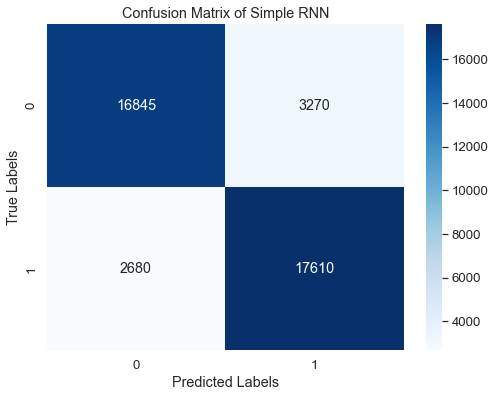

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Simple RNN')
plt.show()

In [21]:
loss, accuracy = model.evaluate(X_train_padded, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8897
Testing Accuracy:  0.8527
